## Crypto Prediction with LSTM: Ethereum (ETH)

- This notebook attempts to use TensorFlow Keras LSTM to predict movement in Crypto prices
- Data is pulled from the CoinApi, so it can be refreshed at any point and retrained
- The models use a 7 day lookback window to produce series data for training and testing
- 2 optimizations were used and an overall R2 score of .90 was attained

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import tensorflow as tf
from copy import deepcopy as dc
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.optimizers import Adam
import datetime as dt


from api_keys import coinapi_key

In [2]:
# Pull ETH data from coinapi

url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_ETH_USD/history?period_id=1DAY&limit=20000'
headers = {'X-CoinAPI-Key' : coinapi_key}
response = requests.get(url, headers=headers)
 
if response.status_code == 200:
    json_data = response.json()
    print(json_data)
else:
    print(f"Error: {response.status_code}")

[{'time_period_start': '2023-12-31T00:00:00.0000000Z', 'time_period_end': '2024-01-01T00:00:00.0000000Z', 'time_open': '2023-12-31T00:00:07.1540000Z', 'time_close': '2023-12-31T21:38:26.6040000Z', 'price_open': 2292, 'price_high': 2320.5, 'price_low': 2277.8, 'price_close': 2287.9, 'volume_traded': 1457.73278691, 'trades_count': 3636}, {'time_period_start': '2023-12-30T00:00:00.0000000Z', 'time_period_end': '2023-12-31T00:00:00.0000000Z', 'time_open': '2023-12-30T00:00:05.1370000Z', 'time_close': '2023-12-30T23:59:24.4210000Z', 'price_open': 2299.5, 'price_high': 2322.7, 'price_low': 2269.2, 'price_close': 2292.1, 'volume_traded': 1888.79436153, 'trades_count': 4268}, {'time_period_start': '2023-12-29T00:00:00.0000000Z', 'time_period_end': '2023-12-30T00:00:00.0000000Z', 'time_open': '2023-12-29T00:00:02.4600000Z', 'time_close': '2023-12-29T23:59:57.7060000Z', 'price_open': 2345.3, 'price_high': 2387.6, 'price_low': 2257.2, 'price_close': 2299.6, 'volume_traded': 12218.41589984, 'trade

In [3]:
#Convert json to pandas df
df = pd.DataFrame(json_data)

df.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-12-31T00:00:00.0000000Z,2024-01-01T00:00:00.0000000Z,2023-12-31T00:00:07.1540000Z,2023-12-31T21:38:26.6040000Z,2292.0,2320.5,2277.8,2287.9,1457.732787,3636
1,2023-12-30T00:00:00.0000000Z,2023-12-31T00:00:00.0000000Z,2023-12-30T00:00:05.1370000Z,2023-12-30T23:59:24.4210000Z,2299.5,2322.7,2269.2,2292.1,1888.794362,4268
2,2023-12-29T00:00:00.0000000Z,2023-12-30T00:00:00.0000000Z,2023-12-29T00:00:02.4600000Z,2023-12-29T23:59:57.7060000Z,2345.3,2387.6,2257.2,2299.6,12218.415900,8891
3,2023-12-28T00:00:00.0000000Z,2023-12-29T00:00:00.0000000Z,2023-12-28T00:00:13.8040000Z,2023-12-28T23:59:42.9760000Z,2382.2,2447.2,2336.6,2345.5,9671.252782,8653
4,2023-12-27T00:00:00.0000000Z,2023-12-28T00:00:00.0000000Z,2023-12-27T00:00:17.3570000Z,2023-12-27T23:59:58.6120000Z,2231.7,2393.1,2212.8,2380.6,17616.491650,11543


In [4]:
#reduce df to x and y columns
data = df[["time_period_start", "price_close"]]

#rename columns
data = data.rename(columns={"time_period_start":"Date","price_close":"Close"})

#convert date to dt, refomat to yyyymmdd
data['Date'] = pd.to_datetime(data['Date']).dt.date

#json return began with most recent date, reversed for plotting/analysis
data = data.reindex(index=data.index[::-1])

#set date as index
data.set_index('Date', inplace=True)

data.head()

,Close
Date,
2017-08-20,298.40
2017-08-21,319.31
2017-08-22,312.22
2017-08-23,315.61
2017-08-24,323.84


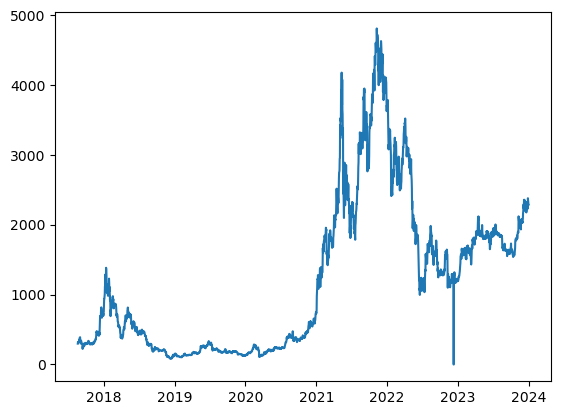

In [5]:
#plot historical eth price
plt.plot(data)

In [6]:
# Set parameters for model

lookback = 7

split_1 = .8
split_2 = .9

In [7]:
# build lookback for lstm training
def prepare_dataframe_for_lstm(data, n_steps):
    data = dc(data)
    
    for i in range(1, n_steps+1):
        data[f'Close(t-{i})'] = data['Close'].shift(i)
        
    data.dropna(inplace=True)
    
    return data

shifted_df = prepare_dataframe_for_lstm(data, lookback)

# name date column from new index (since start date is absorbed into first x windows)
dates = shifted_df.index

#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()

# scale to log
log_transformed_data = np.log(shifted_df_as_np)



# split y from features series
X1 = log_transformed_data[:, 1:]
y1 = log_transformed_data[:, 0]

#flip order of windows (needs to start with most recent)

X1 = dc(np.flip(X1, axis=1))
X1


X1.shape, y1.shape, dates.shape


((2309, 7), (2309,), (2309,))

In [8]:
#Calculate split points based on previously defined variables
train_split = int(len(X1) * split_1)
test_split = int(len(X1) * split_2)

#Define spilt points for train/val/test
dates_train1, X_train1, y_train1 = dates[:train_split],X1[:train_split], y1[:train_split]
dates_val1, X_val1, y_val1 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test1, X_test1, y_test1 = dates[test_split:], X1[test_split:], y1[test_split:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((1847, 7), (1847,), (231, 7), (231,), (231, 7), (231,))

In [9]:
#Build, compile, fit LSTM model

model = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=300)

Epoch 1/300


2023-12-31 16:39:20.035134: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


58/58 [==============================] - 1s 6ms/step - loss: 8.2560 - mean_absolute_error: 2.1237 - val_loss: 0.9771 - val_mean_absolute_error: 0.6098
Epoch 2/300
58/58 [==============================] - 0s 2ms/step - loss: 0.4242 - mean_absolute_error: 0.5325 - val_loss: 0.7729 - val_mean_absolute_error: 0.2202
Epoch 3/300
58/58 [==============================] - 0s 3ms/step - loss: 0.0075 - mean_absolute_error: 0.0642 - val_loss: 0.7762 - val_mean_absolute_error: 0.1665
Epoch 4/300
58/58 [==============================] - 0s 4ms/step - loss: 0.0054 - mean_absolute_error: 0.0548 - val_loss: 0.7733 - val_mean_absolute_error: 0.1619
Epoch 5/300
58/58 [==============================] - 0s 5ms/step - loss: 0.0049 - mean_absolute_error: 0.0515 - val_loss: 0.7714 - val_mean_absolute_error: 0.1561
Epoch 6/300
58/58 [==============================] - 0s 3ms/step - loss: 0.0054 - mean_absolute_error: 0.0551 - val_loss: 0.7690 - val_mean_absolute_error: 0.1498
Epoch 7/300
58/58 [===============

58/58 [==============================] - 0s 851us/step


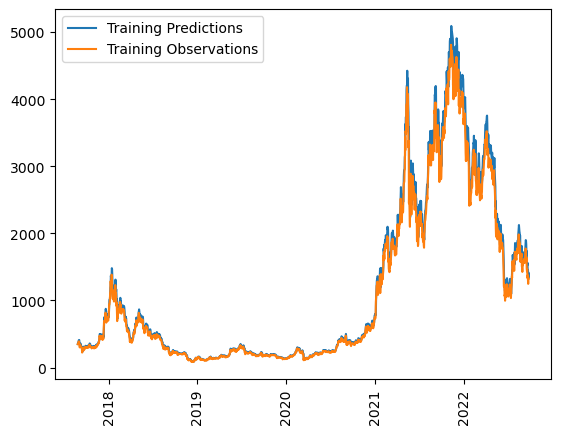

In [10]:
# Check training predictions (use np.exp to transform scaled data back to original scale)

train_predictions = model.predict(X_train1).flatten()

plt.plot(dates_train1, np.exp(train_predictions))
plt.plot(dates_train1, np.exp(y_train1))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [11]:
# Check scores for val period
score = model.evaluate(X_val1, y_val1, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.7086958885192871
Val MAE: 0.165829136967659


8/8 [==============================] - 0s 2ms/step


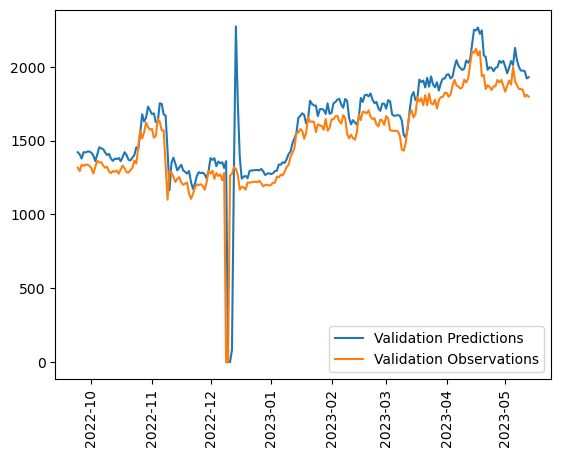

In [12]:
# graphed performance of val data in model
val_predictions = model.predict(X_val1).flatten()

plt.plot(dates_val1, np.exp(val_predictions))
plt.plot(dates_val1, np.exp(y_val1))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [13]:
score = model.evaluate(X_test1, y_test1, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.004695061594247818
Test MAE: 0.06541674584150314


8/8 [==============================] - 0s 2ms/step


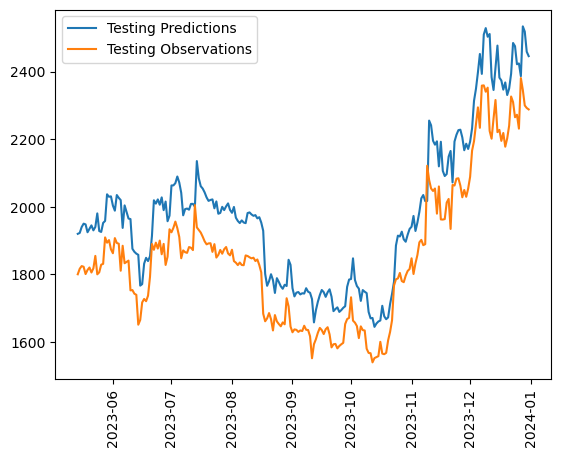

In [14]:
#check model against test data
test_predictions = model.predict(X_test1).flatten()

plt.plot(dates_test1, np.exp(test_predictions))
plt.plot(dates_test1, np.exp(y_test1))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [15]:
# Check r2 score
print('R2 Score: ', r2_score(y_test1, test_predictions))

R2 Score:  0.6062479362958466


## Optimization of the Model

- Adjust the initial data used, limited to the last 50% of the data
- Focus more on recent trends for learning
- Increase Epochs
- Slow learning rate

In [16]:
# Split is changed to begin at 50% of the dataset and continue to the end.
split_1 = .5
split_2 = .89
split_3 = .95


initial_split = int(len(X1) * split_1)
train_split = int(len(X1) * split_2)
test_split = int(len(X1) * split_3)

In [17]:
#change timeframe

dates_train2, X_train2, y_train2 = dates[initial_split:train_split],X1[initial_split:train_split], y1[initial_split:train_split]
dates_val2, X_val2, y_val2 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test2, X_test2, y_test2 = dates[test_split:], X1[test_split:], y1[test_split:]
dates_train2.shape, X_train2.shape, y_train2.shape, \
dates_val2.shape, X_val2.shape, y_val2.shape, \
dates_test2.shape, X_test2.shape, y_test2.shape

((901,), (901, 7), (901,), (138,), (138, 7), (138,), (116,), (116, 7), (116,))

In [18]:
# Build, compile and fit the new model- increased epochs, smaller learning rate
model2 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model2.compile(loss='mse',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['mean_absolute_error'])

model2.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=200)

Epoch 1/200
29/29 [==============================] - 1s 10ms/step - loss: 57.3450 - mean_absolute_error: 7.5491 - val_loss: 54.3115 - val_mean_absolute_error: 7.3695
Epoch 2/200
29/29 [==============================] - 0s 3ms/step - loss: 53.2580 - mean_absolute_error: 7.2743 - val_loss: 50.5287 - val_mean_absolute_error: 7.1082
Epoch 3/200
29/29 [==============================] - 0s 3ms/step - loss: 49.8064 - mean_absolute_error: 7.0342 - val_loss: 47.1738 - val_mean_absolute_error: 6.8681
Epoch 4/200
29/29 [==============================] - 0s 3ms/step - loss: 46.0658 - mean_absolute_error: 6.7640 - val_loss: 42.9220 - val_mean_absolute_error: 6.5513
Epoch 5/200
29/29 [==============================] - 0s 3ms/step - loss: 41.1839 - mean_absolute_error: 6.3937 - val_loss: 37.2969 - val_mean_absolute_error: 6.1069
Epoch 6/200
29/29 [==============================] - 0s 3ms/step - loss: 34.9168 - mean_absolute_error: 5.8825 - val_loss: 30.3215 - val_mean_absolute_error: 5.5063
Epoch 7/2

29/29 [==============================] - 0s 918us/step


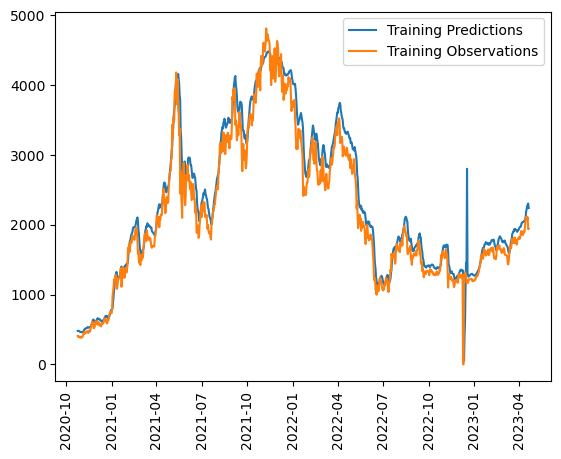

In [19]:
#Second model observations
train_predictions2 = model2.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions2))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [20]:
score = model2.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.00864515919238329
Val MAE: 0.08967790752649307


5/5 [==============================] - 0s 2ms/step


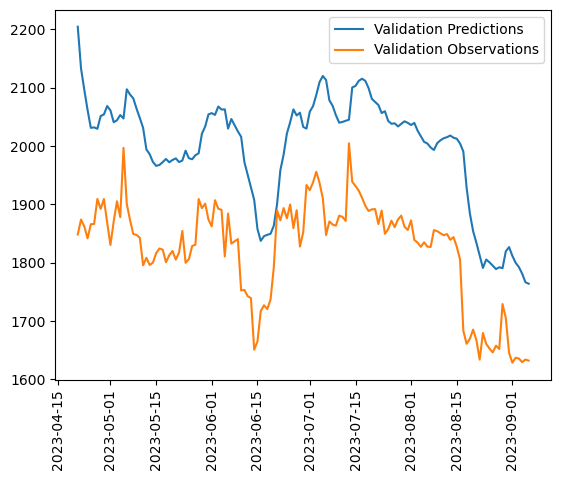

In [21]:
#Second model observations
val_predictions2 = model2.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions2))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [22]:
#MSAE Score for second model
score = model2.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.006808941718190908
Test MAE: 0.07832770049571991


In [23]:
# R2 score for second model
y_pred = model2.predict(X_test2)
print('R2 Score: ', r2_score(y_test2, y_pred))

4/4 [==============================] - 0s 2ms/step
R2 Score:  0.6669403705712285


4/4 [==============================] - 0s 1ms/step


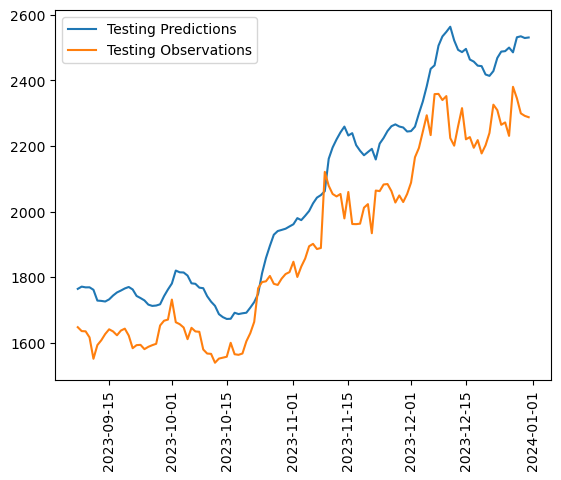

In [24]:
#Second model observations
test_predictions2 = model2.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions2))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [25]:
# Second optimization. Increased neural density, epochs
model3 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(1)])

model3.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model3.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=300)

Epoch 1/300
29/29 [==============================] - 1s 14ms/step - loss: 31.5652 - mean_absolute_error: 5.1386 - val_loss: 1.6994 - val_mean_absolute_error: 1.3028
Epoch 2/300
29/29 [==============================] - 0s 3ms/step - loss: 1.5891 - mean_absolute_error: 1.0137 - val_loss: 0.0566 - val_mean_absolute_error: 0.2333
Epoch 3/300
29/29 [==============================] - 0s 3ms/step - loss: 0.5179 - mean_absolute_error: 0.4699 - val_loss: 0.0062 - val_mean_absolute_error: 0.0645
Epoch 4/300
29/29 [==============================] - 0s 3ms/step - loss: 0.4515 - mean_absolute_error: 0.4131 - val_loss: 0.0028 - val_mean_absolute_error: 0.0484
Epoch 5/300
29/29 [==============================] - 0s 3ms/step - loss: 0.4409 - mean_absolute_error: 0.4041 - val_loss: 0.0066 - val_mean_absolute_error: 0.0681
Epoch 6/300
29/29 [==============================] - 0s 3ms/step - loss: 0.4286 - mean_absolute_error: 0.3955 - val_loss: 0.0055 - val_mean_absolute_error: 0.0675
Epoch 7/300
29/29 [=

29/29 [==============================] - 0s 937us/step


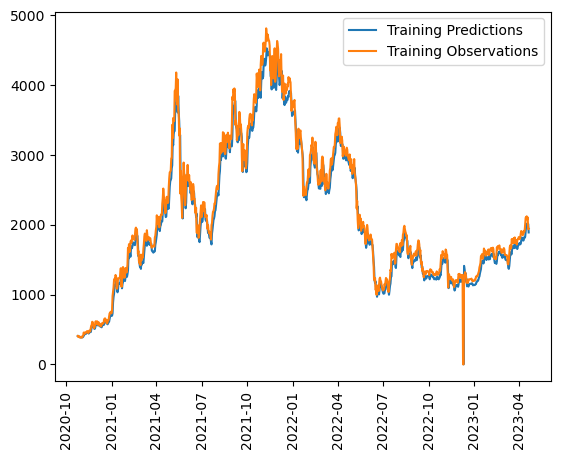

In [26]:
#Third model observations
train_predictions3 = model3.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions3))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [27]:
score = model3.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0022660591639578342
Val MAE: 0.04387979954481125


5/5 [==============================] - 0s 2ms/step


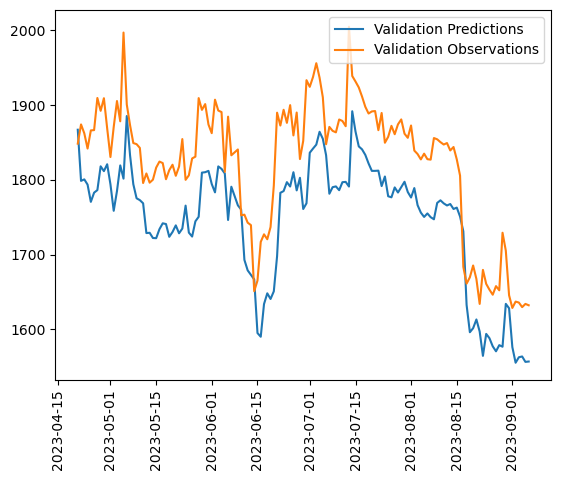

In [28]:
#Second model observations 
val_predictions3 = model3.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions3))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [29]:
# Third Model MAE score
score = model3.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.002916589379310608
Test MAE: 0.048678651452064514


4/4 [==============================] - 0s 2ms/step


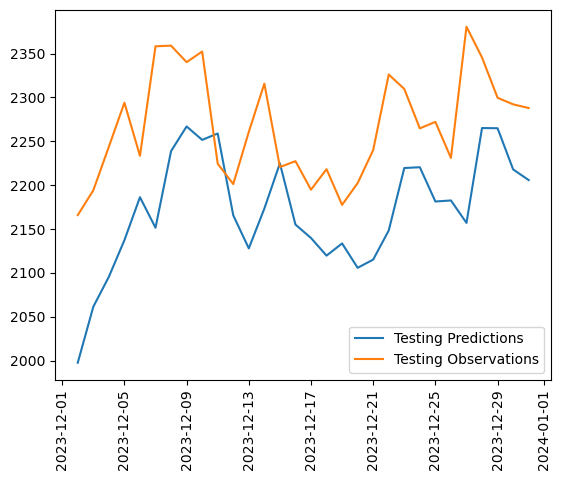

In [30]:
test_predictions3 = model3.predict(X_test2).flatten()

plt.plot(dates_test2[-30:], np.exp(test_predictions3[-30:]))
plt.plot(dates_test2[-30:],np.exp(y_test2[-30:]))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [31]:
# R2 score for second model

print('R2 Score: ', r2_score(y_test2, test_predictions3))

R2 Score:  0.8573350637388246


## Future Prediction
- Attempting to look ahead x days in an attempt to predict upcoming trends
- We are using the best scoring model for testing predictions

In [32]:
# Initialize an array to store predictions
predictions = []
predicted_dates = []
prediction_range = 7
#create list of numbers to add to date based on date range
date_range = list(range(1, prediction_range +1))

# Use the last n_steps data points from the training set to make predictions
current_batch = X_test2[-1]
current_reshape = current_batch.reshape((1, lookback))
initial_date = dates_test2[-1]

# Generate predictions for 7 days
for i in range(prediction_range): # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model3.predict(current_reshape)[0,0]
    
    # Append the prediction to the list of predictions
    predictions.append(current_pred)
        

    # Update initial input for the next step
    updated_batch = np.insert(current_batch, -1, current_pred)
    
    #resize batch 
    current_batch = updated_batch[1:]
    
    #reshape batch
    current_reshape = current_batch.reshape((1, lookback))

#Adding future dates at the end of the dateset   
for day in date_range:
    new_date = initial_date + dt.timedelta(days=day)
    predicted_dates.append(new_date
                          )
# 'predictions' contains 7-day forecast
print(predictions)

for date in predicted_dates:
    print(date)

1/1 [==============================] - 0s 10ms/step
[7.698827, 7.6933713, 7.6942186, 7.693295, 7.691019, 7.6892858, 7.688636]
2024-01-01
2024-01-02
2024-01-03
2024-01-04
2024-01-05
2024-01-06
2024-01-07


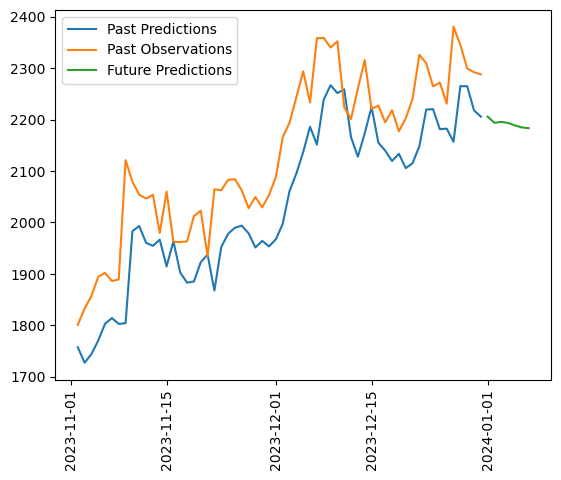

In [33]:
#Plot last 60 days of testing plus future prediction
plt.plot(dates_test2[-60:], np.exp(test_predictions3[-60:]))
plt.plot(dates_test2[-60:],np.exp(y_test2[-60:]))
plt.plot(predicted_dates, np.exp(predictions))
plt.xticks(rotation=90)
plt.legend(['Past Predictions', 'Past Observations','Future Predictions'])

In [34]:
# Export model to HDF5 file
model.save("H5_Files/eth_7_day_1.h5")

In [35]:
# Export model to HDF5 file
model2.save("H5_Files/eth_7_day_2.h5")

In [36]:
# Export model to HDF5 file
model3.save("H5_Files/eth_7_day_3.h5")

In [37]:
# build output into a df for graphing in js

df = pd.DataFrame({"Date": dates_test2[-90:], "observed":np.exp(y_test2[-90:]),\
                "model_1_predicted":np.exp(test_predictions[-90:]),\
                "model_2_predicted":np.exp(test_predictions2[-90:]),\
                "model_3_predicted":np.exp(test_predictions3[-90:])})
df.set_index('Date', inplace=True)


df

,observed,model_1_predicted,model_2_predicted,model_3_predicted
Date,,,,
2023-10-03,1657.1,1783.209839,1815.184692,1594.004761
2023-10-04,1647.0,1765.364380,1814.666260,1578.711304
2023-10-05,1611.4,1757.626709,1805.220215,1573.365723
2023-10-06,1646.0,1721.470947,1781.675659,1545.428833
2023-10-07,1635.0,1753.416138,1780.138672,1565.946899
...,...,...,...,...
2023-12-27,2380.6,2386.273438,2485.635254,2156.919678
2023-12-28,2345.5,2533.605225,2531.599365,2265.074219
2023-12-29,2299.6,2518.063477,2534.576660,2264.855957


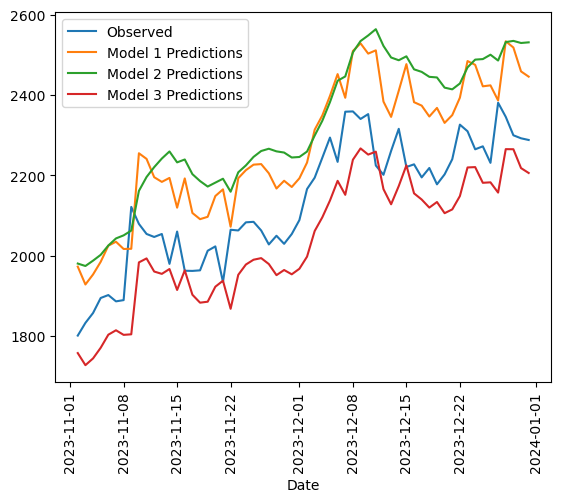

In [38]:
#Measuring each model's predictions against the test data
df[-60:].plot(use_index=True)
plt.xticks(rotation=90)

plt.legend(['Observed', 'Model 1 Predictions', 'Model 2 Predictions', \
            'Model 3 Predictions'])
plt.show()

In [39]:
#output prediction data to csv
df.to_csv('output/eth_predict.csv') 

In [40]:
#output original historical data to csv
data.to_csv('output/eth_lifetime.csv')

In [41]:
#Scores for each model

print('Model 1 R2 Score: ', r2_score(y_test1, test_predictions))
print('Model 2 R2 Score: ', r2_score(y_test2, test_predictions2))
print('Model 3 R2 Score: ', r2_score(y_test2, test_predictions3))

Model 1 R2 Score:  0.6062479362958466
Model 2 R2 Score:  0.6669403705712285
Model 3 R2 Score:  0.8573350637388246
